<a href="https://colab.research.google.com/github/tomek-l/fire/blob/master/gradCAM_on_never_seen_data(DryCreek).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Verify the model on never seen images


In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
from keras.models import load_model
model = load_model('/gdrive/My Drive/FireVideo/models/VGG_monolth_30epochs.h5')

Using TensorFlow backend.
W0708 11:20:48.687409 140377666688896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 11:20:48.742060 140377666688896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 11:20:48.793910 140377666688896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0708 11:20:49.206942 140377666688896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 11:20:49.208703 14

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np

def get_processed_image(img_path):
  img = image.load_img(img_path, target_size=(150, 150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255. #(the network is trained on 0.0-1.0 inputs)
  return img_tensor

In [4]:
#Build graph for CAM-grad process
import keras.backend as K

binary_fire_output = model.output
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(model.output, last_conv_layer.output)[0]
print(grads)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads)

Tensor("gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 9, 9, 512), dtype=float32)
Tensor("Mean:0", shape=(512,), dtype=float32)


In [5]:
!ls '/gdrive/My Drive/FireVideo/dry_creek/dry_creek_0.2fps/'

dry_creek10.png  dry_creek17.png  dry_creek23.png  dry_creek5.png
dry_creek11.png  dry_creek18.png  dry_creek24.png  dry_creek6.png
dry_creek12.png  dry_creek19.png  dry_creek25.png  dry_creek7.png
dry_creek13.png  dry_creek1.png   dry_creek26.png  dry_creek8.png
dry_creek14.png  dry_creek20.png  dry_creek2.png   dry_creek9.png
dry_creek15.png  dry_creek21.png  dry_creek3.png
dry_creek16.png  dry_creek22.png  dry_creek4.png


### Let's try CAM grad process on one image from dataset

#Let's run the process on more pictures

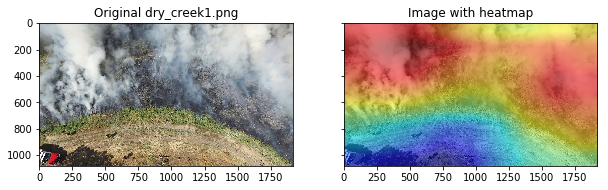

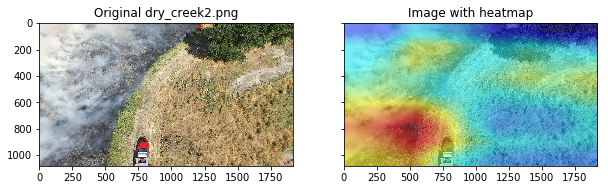

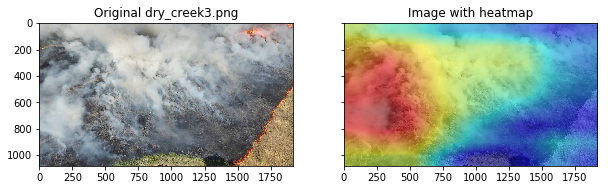

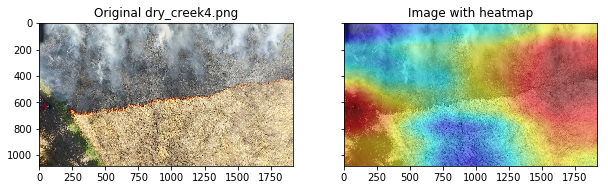

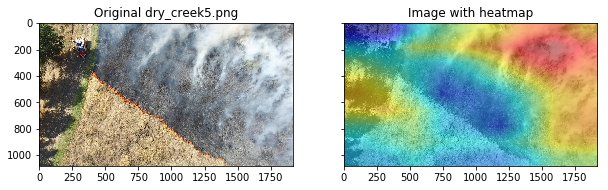

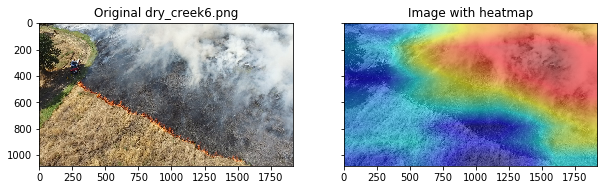

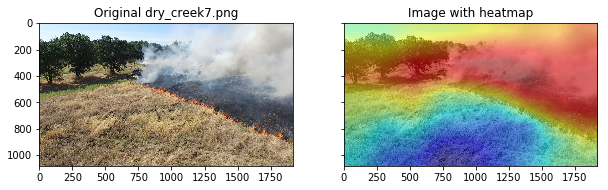

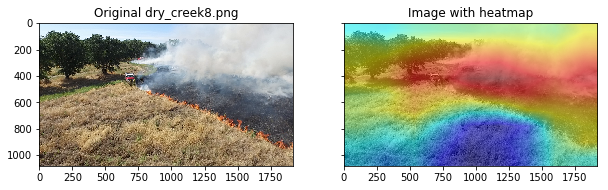

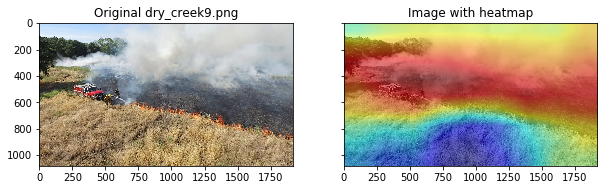

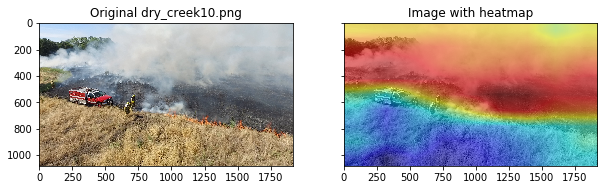

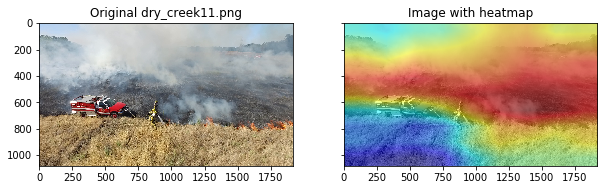

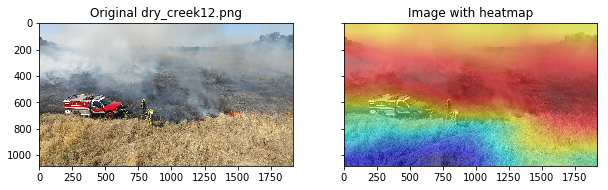

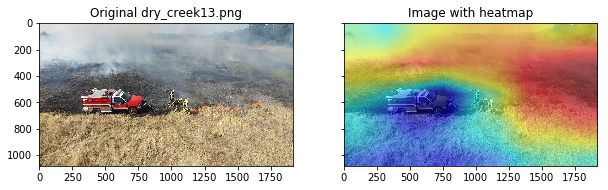

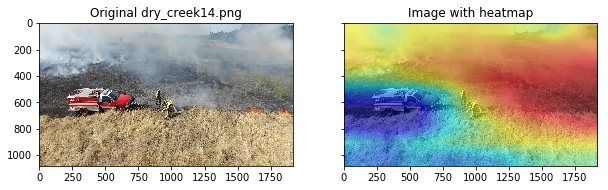

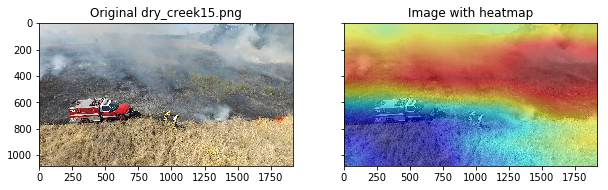

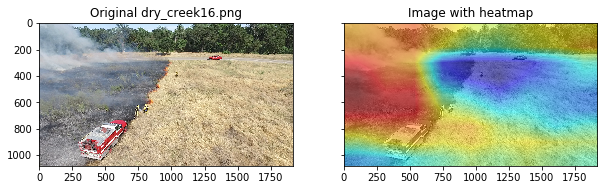

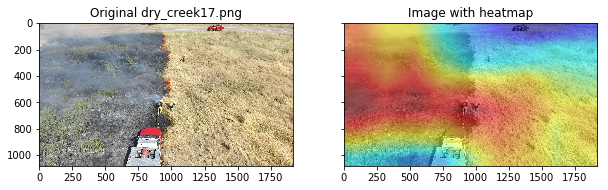

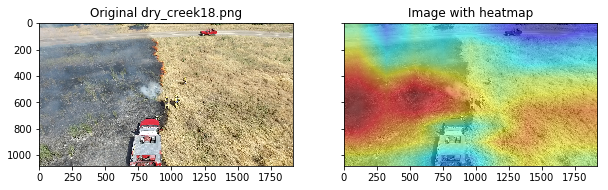

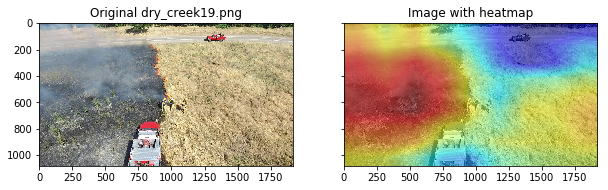

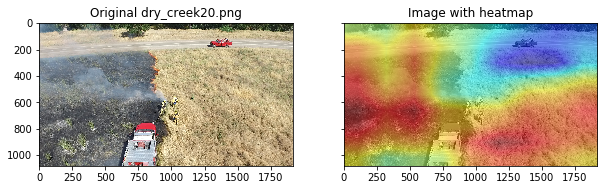

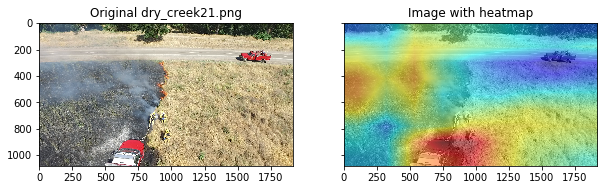

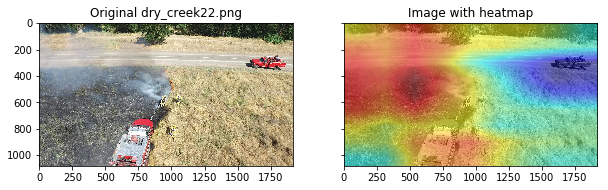

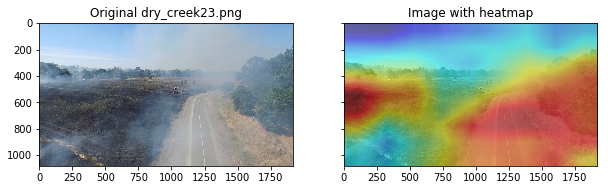

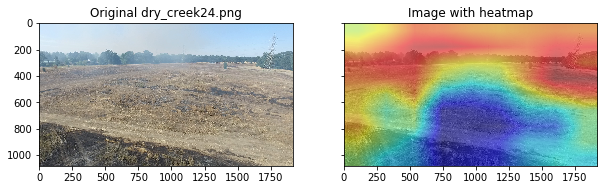

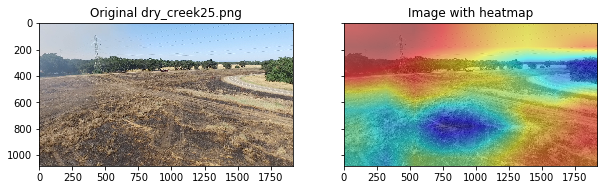

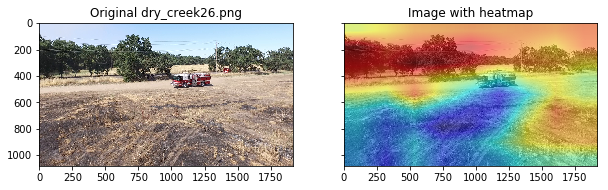

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
dir = '/gdrive/My Drive/FireVideo/dry_creek/dry_creek_0.2fps/'

for idx, name in enumerate(os.listdir(dir)):
 
  if idx == 100: break # do just 100 examples
  img_path = dir + name
  img_tensor = get_processed_image(img_path)

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
  for i in range(512):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)

  heatmap_amplitude = np.max(heatmap)-np.min(heatmap)
  min_heatmap = np.min(heatmap)

  heatmap = (heatmap+np.abs(min_heatmap))/heatmap_amplitude

  img = cv2.imread(img_path)
  grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  grayimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2BGR)
  
  rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = np.uint8(0.5* heatmap + 0.5* grayimg)
  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
  ax1.imshow(rgbimg)
  ax1.set_title('Original ' + name)
  ax2.imshow(superimposed_img)  
  ax2.set_title('Image with heatmap')
  
  
  plt.show()
  
#   cv2.imwrite('/gdrive/My Drive/FireVideo/heatmaps/'+name.split('.')[0]+'_heatmap.jpg',
#               cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
#   cv2.imwrite('/gdrive/My Drive/FireVideo/heatmaps/'+name, img)